## Building a Predictive Sales Dashboard using Amazon Redshift, QuickSight, and SageMaker

### 1. Create an Amazon Redshift cluster to store the sales data.


In [ ]:
CREATE TABLE sales(
    TV varchar NOT NULL,
    Radio varchar NOT NULL,
    Newspaper varchar NOT NULL,
    Sales varchar NOT NULL
);

In [ ]:
COPY sales
FROM 's3://practice-project-bucket/sales.csv'
csv
IGNOREHEADER 1
REGION 'us-east-1'
IAM_ROLE default;

### 2. Create an Amazon SageMaker notebook instance to build a machine learning model to predict future sales:


### (Simple Linear Regression)

### Problem Statement
Build a model which predicts sales based on the money spent on different platforms for marketing.

In this notebook, we'll build a linear regression model to predict Sales using an appropriate predictor variable

In [97]:
import boto3
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [54]:
#Read the data 
ads_data =  pd.read_csv('advertising.csv')

In [98]:
ads_data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [56]:
ads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [57]:
#Remove null values
ads_data.isnull().sum()*100/ads_data.shape[0]

TV           0.0
Radio        0.0
Newspaper    0.0
Sales        0.0
dtype: float64

### Exploratory Data Analysis

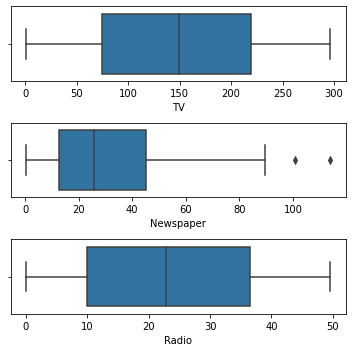

In [58]:
fig, axs = plt.subplots(3, figsize = (5,5))
plt1 = sns.boxplot(ads_data['TV'], ax = axs[0])
plt2 = sns.boxplot(ads_data['Newspaper'], ax = axs[1])
plt3 = sns.boxplot(ads_data['Radio'], ax = axs[2])
plt.tight_layout()

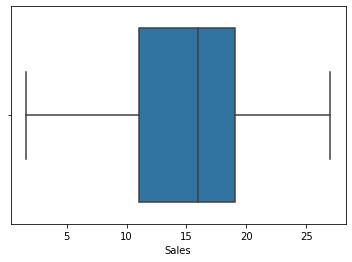

In [60]:
sns.boxplot(ads_data['Sales'])
plt.show()

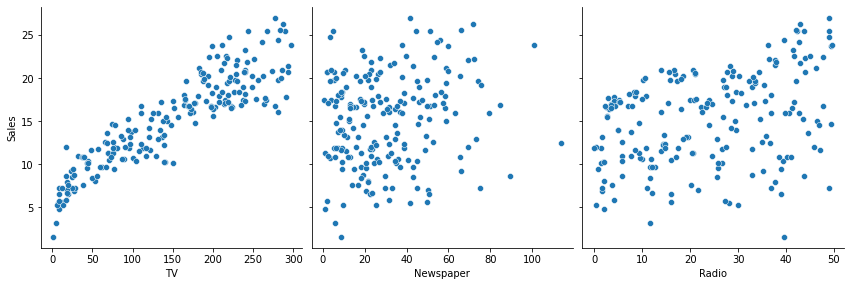

In [63]:
# Let's see how Sales are related with other variables using scatter plot.
sns.pairplot(ads_data, x_vars=['TV', 'Newspaper', 'Radio'], y_vars='Sales', height=4, aspect=1, kind='scatter')
plt.show()

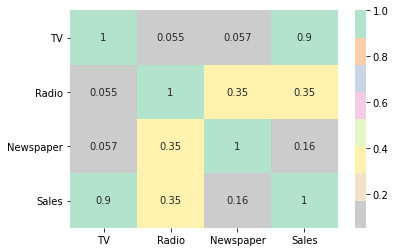

In [75]:
# Let's see the correlation between different variables.
sns.heatmap(ads_data.corr(), cmap="Pastel2_r", annot = True)
plt.show()

As is visible from the pairplot and the heatmap, the variable TV seems to be most correlated with Sales. So let's go ahead and perform simple linear regression using TV as our feature variable.

### Model Building 

Equation of linear regression
y=c+m1x1+m2x2+...+mnxn
 
y is the response

c is the intercept

m1 is the coefficient for the first feature

mn is the coefficient for the nth feature

In our case:

y=c+m1×TV
 
The  m values are called the model coefficients or model parameters.



In [76]:
X = ads_data['TV']
y = ads_data['Sales']

### Train and Test Split

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state= 100)

In [81]:
import statsmodels.api as sm

In [82]:
# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the resgression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

In [83]:
# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const    6.948683
TV       0.054546
dtype: float64

In [84]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     611.2
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           1.52e-52
Time:                        16:00:17   Log-Likelihood:                -321.12
No. Observations:                 140   AIC:                             646.2
Df Residuals:                     138   BIC:                             652.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9487      0.385     18.068      0.0

#### Looking at some key statistics from the summary
The values we are concerned with are -

The coefficients and significance (p-values)
R-squared
F statistic and its significance
1. The coefficient for TV is 0.054, with a very low p value
The coefficient is statistically significant. So the association is not purely by chance.

2. R - squared is 0.816
Meaning that 81.6% of the variance in Sales is explained by TV

This is a decent R-squared value.

3. F statistic has a very low p value (practically low)
Meaning that the model fit is statistically significant, and the explained variance isn't purely by chance.

The fit is significant. Let's visualize how well the model fit the data.

From the parameters that we get, our linear regression equation becomes:

Sales=6.948+0.054×TV

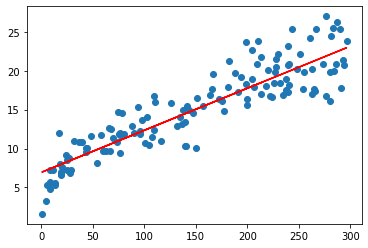

In [85]:
plt.scatter(X_train, y_train)
plt.plot(X_train, 6.948 + 0.054*X_train, 'r')
plt.show()


### Model Evaluation
##### Residual analysis
To validate assumptions of the model, and hence the reliability for inference
##### Distribution of the error terms
We need to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [86]:
y_train_pred = lr.predict(X_train_sm)
res = (y_train - y_train_pred)

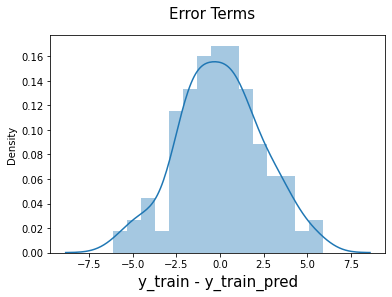

In [87]:
fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

#### Looking for patterns in the residuals

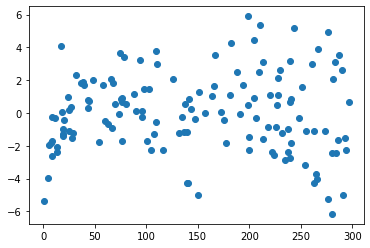

In [88]:
plt.scatter(X_train,res)
plt.show()

### Predictions on the Test Set
Now that you have fitted a regression line on your train dataset, it's time to make some predictions on the test data. For this, you first need to add a constant to the X_test data like you did for X_train and then you can simply go on and predict the y values corresponding to X_test using the predict attribute of the fitted regression line.

In [89]:
# Add a constant to X_test
X_test_sm = sm.add_constant(X_test)

# Predict the y values corresponding to X_test_sm
y_pred = lr.predict(X_test_sm)

In [90]:
y_pred.head()

126     7.374140
104    19.941482
99     14.323269
92     18.823294
111    20.132392
dtype: float64

In [91]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [92]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

2.019296008966233

In [94]:
#Checking the R-squared on the test set
r_squared = r2_score(y_test, y_pred)
r_squared

0.7921031601245658

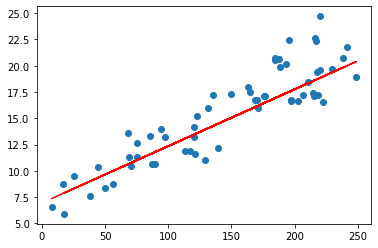

In [95]:
#Vizualizing the fit on the test set 
plt.scatter(X_test, y_test)
plt.plot(X_test, 6.948 + 0.054 * X_test, 'r')
plt.show()

### 3.  Create an Amazon QuickSight dashboard to visualize the sales data and the predictions from the machine learning model.

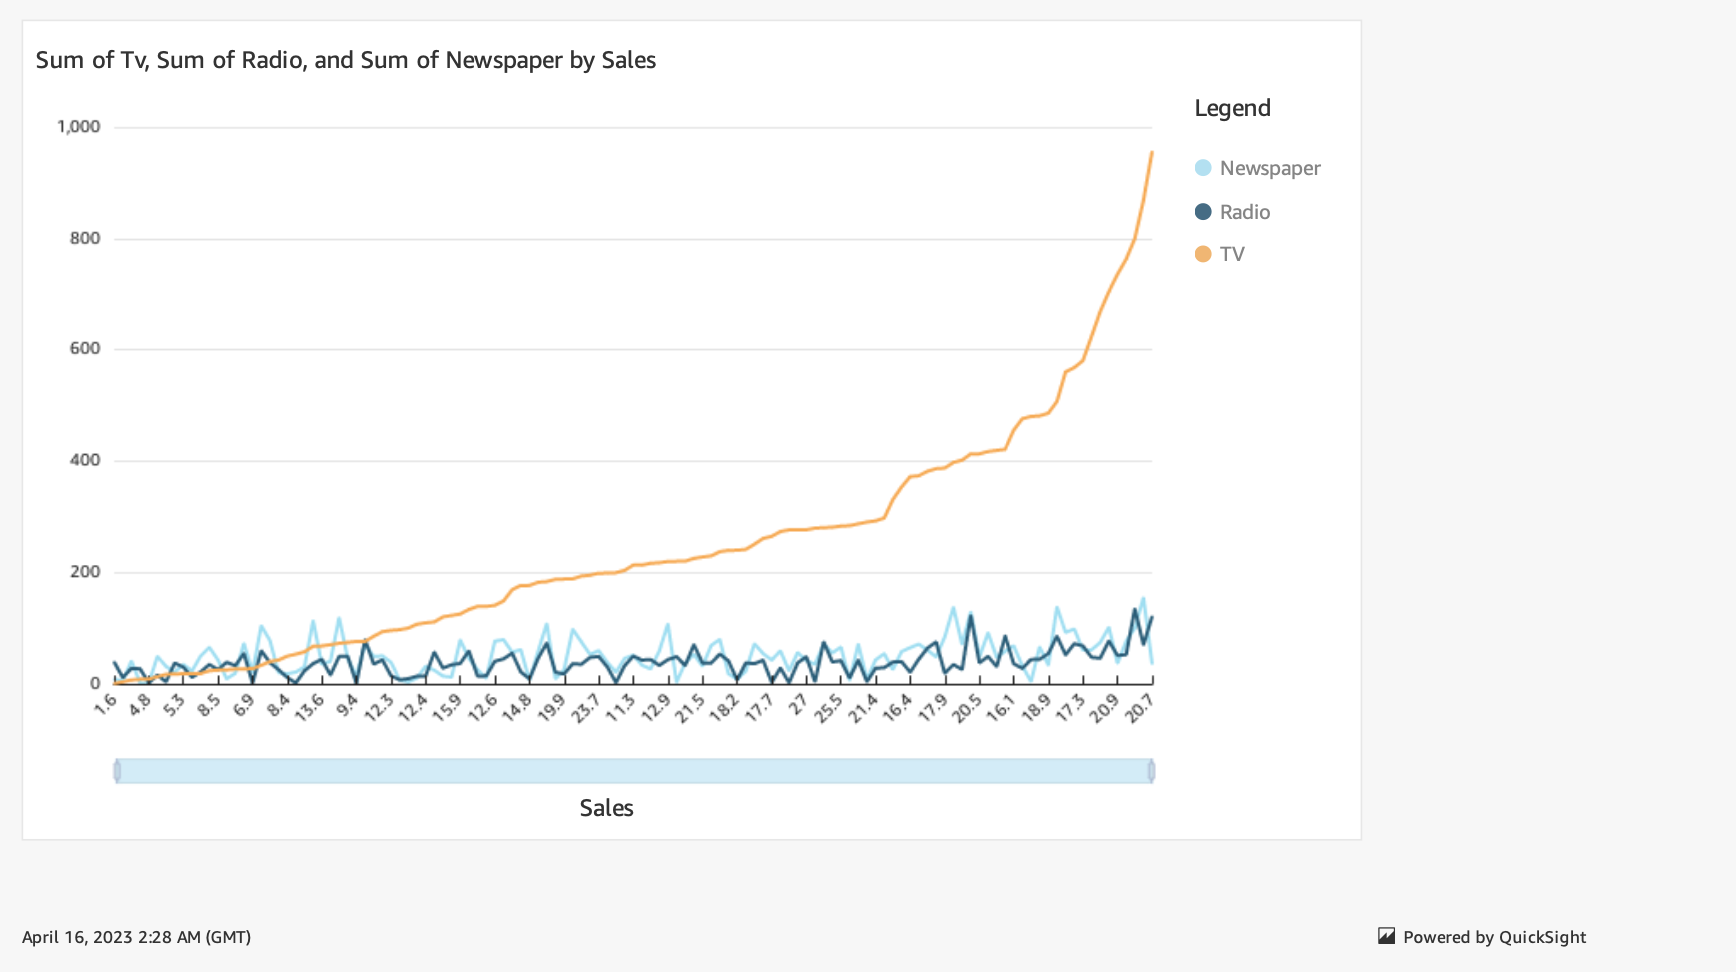

Note: The above dashboard is a vizualization of Advertise expences of 3 different platform vs sales. This dashboard does not vizualize the predictions from the above machine learning model because this model is not deployed to endpoint to add the calculated field to predict the future sales. This can be done by creating a new calculated field and adding the below method in the formula.

##### predict('sagemaker-model-endpoint', 'sagemaker-model', [date_value])[0]
Here, 'sagemaker-model-endpoint' is the Amazon SageMaker endpoint for the deployed machine learning model, 'sagemaker-model' is the name of the model, and 'date_value' is the date for which you want to predict the sales.